## Test model predictions

In [1]:
from reframed import pFBA, Environment, FVA, FBA, load_cbmodel, plot_flux_envelope, gene_knockout
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import sys
sys.path.append("../functions/")
import EGC

#### Loading model

In [2]:
model = load_cbmodel('../models/RcH10_final.xml', flavor='bigg')

## Growth on media used during reconstruction

In [3]:
media = pd.read_csv('../input/media_db.tsv',sep='\t')
media = media.groupby('medium').agg({'compound': set})['compound'].to_dict()

In [4]:
growth = {}

for medium_id, cpds in media.items():
    env = Environment.from_compounds(cpds)
    env.apply(model, exclusive=True, inplace=False, warning=False)
    sol = FBA(model
)
    growth[medium_id]=sol.fobj

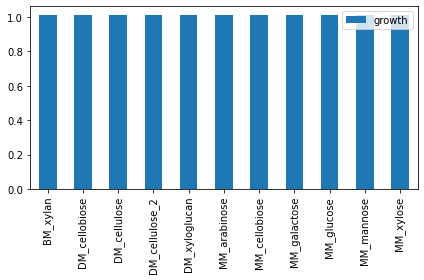

In [5]:
df = pd.DataFrame({'growth': growth})
df.sort_values('growth', inplace=True)
df.plot.bar()
plt.tight_layout()
plt.savefig('../figures/growth_on_carbon_sources.png', dpi=300)

## Production envelopes for various fermentation products.

In [6]:
env_cellb = Environment.from_compounds(media["DM_cellobiose"])

In [7]:
chemostat= pd.read_excel('../input/Guedon1999_chemostat_data.xlsx', sheet_name='Sheet1', header=None, index_col=0, usecols="A:H")
mu = chemostat.iloc[0,:].values
q_cellb = chemostat.iloc[1,:].values
q_ac = chemostat.iloc[2,:].values * chemostat.iloc[3,:].values / 100
q_lac = chemostat.iloc[2,:].values * chemostat.iloc[4,:].values / 100
q_etoh = chemostat.iloc[2,:].values * chemostat.iloc[5,:].values / 100

In [8]:
model = load_cbmodel('../models/RcH10_final.xml', flavor='bigg')

In [9]:
# predict max growth rate (secretion is constrained)
mu_sim = []

for i, mu_i in enumerate(mu):
    constraints = {
        'R_EX_cellb_e': (-q_cellb[i], -q_cellb[i]),
        'R_EX_ac_e':(q_ac[i], q_ac[i]),
        'R_EX_lac__L_e':(q_lac[i], q_lac[i]),
        'R_EX_etoh_e':(q_etoh[i], q_etoh[i]),
    }
    sol = FBA(model, constraints=constraints)
    mu_i = sol.fobj if sol.fobj is not None else 0
    mu_sim.append(mu_i)

CPU times: user 34.3 s, sys: 892 ms, total: 35.2 s
Wall time: 36.7 s


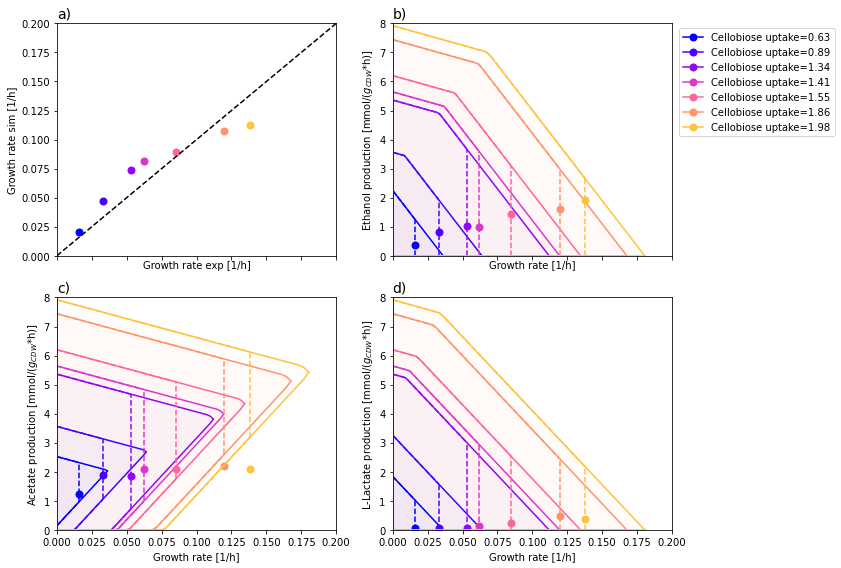

In [28]:
%%time
fig, axs = plt.subplots(2,2, figsize=(12,8), sharey=False, sharex=True)

rxns = ["R_EX_ac_e","R_EX_etoh_e","R_EX_lac__L_e"]
exp_data = [q_ac,q_etoh,q_lac]

colors = mpl.colormaps["gnuplot2"](np.linspace(0.25,0.8,len(q_cellb)))

model_copy = model.copy()

i = 1

for rxn, q_exp in zip(rxns,exp_data):
    j=1 if i>1 else 0
    ax = axs[np.mod(i,2),j]
    
    for q_exp_i,q_cellb_i,mu_i,color_i in zip(q_exp,q_cellb,mu,colors): #,color colors
        env_cellb['R_EX_cellb_e'] = (-q_cellb_i, 0)
        env_cellb.apply(model, exclusive=True, inplace=True, warning=False)
        env_cellb.apply(model_copy, exclusive=True, inplace=True, warning=False)
        
        model_copy.reactions.R_Growth.ub = mu_i
        plot_flux_envelope(model_copy,"R_Growth",rxn,ax=ax,steps=50,plot_kwargs={"color":color_i,"linestyle":"--"}, fill_kwargs={"color":color_i,"alpha":0.0},)
        plot_flux_envelope(model,"R_Growth",rxn,ax=ax,steps=50,plot_kwargs={"color":color_i}, fill_kwargs={"color":color_i,"alpha":0.02},)
        
        ax.plot([mu_i],[q_exp_i],color=color_i,marker='o',markersize=7,label=f"Cellobiose uptake={q_cellb_i}")
    met = model.reactions[rxn].get_substrates()[0]
    name = model.metabolites[met].name
    
    ax.set_ylim([0,8])
    ax.set_xlim([0,0.2])
    
    ax.set_ylabel(name + " production [mmol/($g_{CDW}$*h)]")#,fontsize=12)
    ax.set_xlabel("Growth rate [1/h]")#,fontsize=12)
    i +=1

for mu_i,mu_sim_i,color_i in zip(mu,mu_sim,colors):
    axs[0,0].plot([mu_i], [mu_sim_i], 'o',markersize=7,color=color_i) 

axs[0,0].set_ylabel('Growth rate sim [1/h]')#,fontsize=12)
axs[0,0].set_xlabel('Growth rate exp [1/h]')#,fontsize=12)
axs[0,0].plot(np.linspace(0,0.2,100), np.linspace(0,0.2,100),'--',color="black")
axs[0,0].set_ylim([0,0.2])
axs[0,0].set_xlim([0,0.2])

axs[0,0].set_title("a)",fontsize=14,loc="left")
axs[0,1].set_title("b)",fontsize=14,loc="left")
axs[1,0].set_title("c)",fontsize=14,loc="left")
axs[1,1].set_title("d)",fontsize=14,loc="left")

axs[0,1].legend(bbox_to_anchor=(1.6, 1))#,fontsize=12)
plt.tight_layout()
plt.savefig("../figures/flux_envelopes.png")

## Gene deletion experiments 

In [11]:
sugars = {
    'Arabinose': 'arab__L',
    'Glucose': 'glc__D',
    'Cellobiose': 'cellb',
    'Galactose': 'gal',
    'Xylose': 'xyl__D',
    'Mannose': 'man',
}

genes = {
    'MTL2109': 'G_WP_015925554_1',
    'MTL3221': 'G_WP_015926569_1',
    'MTL3238': 'G_WP_015926586_1',
    'MTL3429': 'G_WP_015926769_1',
    'MTL3431': 'G_WP_015926771_1',
}

In [12]:
mutant_growth = pd.read_excel('../input/Kampik_2021_mutants.xlsx', sheet_name="gene_deletion_boolean", usecols="A:H")
mutant_growth = mutant_growth.melt(id_vars=['Mutant'], value_vars=sugars.keys(), var_name='Sugar', value_name='Growth').dropna()

In [13]:
env_init=Environment.from_compounds(media['MM_glucose'])
del env_init['R_EX_glc__D_e']
env_init.apply(model, exclusive=True, inplace=True, warning=False)

In [14]:
data = []

for i, row in mutant_growth.iterrows():
    
    ko = [genes[row['Mutant']]]
    constraints = {f'R_EX_{sugars[row["Sugar"]]}_e': (-10, 0)}
    sol = gene_knockout(model, ko, constraints=constraints)
    data.append('Yes' if (sol.fobj is not None and sol.fobj > 0.001) else 'No')

mutant_growth['Predicted'] = data

In [15]:
mutant_growth.sort_values(['Mutant', 'Sugar'])

,Mutant,Sugar,Growth,Predicted
10,MTL2109,Cellobiose,No,No
1,MTL3221,Arabinose,Yes,Yes
11,MTL3221,Cellobiose,No,No
6,MTL3221,Glucose,No,No
26,MTL3221,Mannose,No,No
2,MTL3238,Arabinose,Yes,Yes
17,MTL3238,Galactose,No,No
3,MTL3429,Arabinose,Yes,Yes
23,MTL3429,Xylose,Yes,Yes
4,MTL3431,Arabinose,Yes,Yes


### Checking for energy generating cycles

In [16]:
EGC.EGC_identifier(model)

There are NO energy producing cycles in the model


{}

### Model content

In [17]:
model.summary()

Metabolites:
C_c 751
C_p 123
C_e 181

Reactions:
enzymatic 846
transport 332
exchange 174
sink 2
other 185


In [18]:
len(model.genes)

728

In [19]:
import reframed

In [20]:
model_draft = load_cbmodel("../models/RcH10_draft.xml")
model_draft.id = "CarveMe draft"
model.id = "iIB728"

model_iFS431 = load_cbmodel("../models/iFS431.xml",load_gprs=False,flavor="cobra")
model_iFS431.id = "iFS431"

In [21]:
from collections import OrderedDict

In [22]:
summary = OrderedDict()

for model_iter in [model_iFS431,model_draft,model]:
    

    print(model_iter.id)
    if model_iter.id == "iFS431":
        genes = 431
        exchange = 31
        internal = 663
        transport = 79
        
        comp_c = 679
        comp_e = 79
        summary[model_iter.id] = {"genes": {"genes":genes},
                                  "reactions":{"exchange":exchange,
                                             "internal":internal,
                                             "transport":transport},
                                  "metabolites":{"internal":comp_c,
                                                 "external":comp_e}
                                 }

    else:
        
        genes = len(model_iter.genes)
    
        exchange = len(model_iter.get_reactions_by_type(reframed.ReactionType.EXCHANGE))
        internal = len(model_iter.get_reactions_by_type(reframed.ReactionType.ENZYMATIC))
        transport = len(model_iter.get_reactions_by_type(reframed.ReactionType.TRANSPORT))
        other = len(model_iter.get_reactions_by_type(reframed.ReactionType.OTHER)) + len(model.get_reactions_by_type(reframed.ReactionType.SINK))

        comp_c = len(model_iter.get_compartment_metabolites("C_c"))
        comp_e = len(model_iter.get_compartment_metabolites("C_p"))+len(model_iter.get_compartment_metabolites("C_e"))
    
    
        summary[model_iter.id] = {"genes": {"genes":genes},
                                  "reactions":{"exchange":exchange,
                                             "internal":internal+other,
                                             "transport":transport},
                                  "metabolites":{"internal":comp_c,
                                                 "external":comp_e}
                                 }

iFS431
CarveMe draft
iIB728


In [23]:
663+31+79

773

In [24]:
679+79

758

In [25]:

colors = OrderedDict()
for element,values in summary["iIB728"].items():
    colors[element]={}
    for i,subcat in enumerate(values.keys()):
        if element=="genes":
            colors[element][subcat]= plt.cm.YlOrBr(0.5-i*0.2) 
        elif element=="reactions":
            colors[element][subcat]= plt.cm.Reds(0.9-i*0.2) 
        elif element=="metabolites":
            colors[element][subcat]= plt.cm.Blues(0.9-i*0.4) 

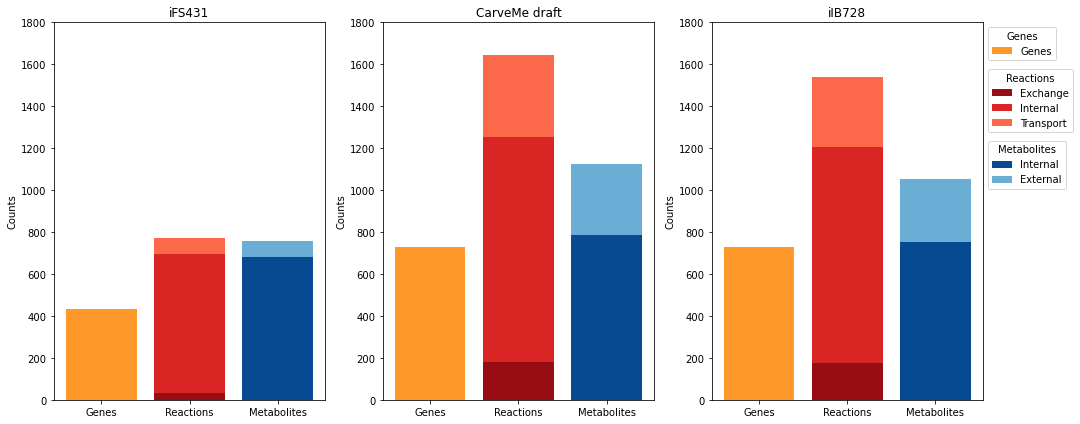

In [26]:
fig,ax = plt.subplots(1,3,figsize=(15,6))

for j,model_id in enumerate(summary.keys()):
    
    x = np.arange(len(summary[model_id].keys()))
    legends = {}
    for i, element in enumerate(summary[model_id]):
        bottom = 0 
        legends[element] = []
        for subcat,value in summary[model_id][element].items():
            plot_color = ax[j].bar(i, value, bottom=bottom,color=colors[element][subcat], label=subcat[0].capitalize() +subcat[1:])
            legends[element].append(plot_color)
            bottom += value  
    ax[j].set_xticks(x, [key[0].capitalize()+key[1:] for key in summary[model_id].keys()])
    ax[j].set_ylabel('Counts')
    ax[j].set_title(model_id)
    ax[j].set_ylim([0,1800])

first_legend =  plt.legend(handles= legends["genes"],loc="upper left",bbox_to_anchor=(1,1),title="Genes")
second_legend = plt.legend(handles= legends["reactions"],loc="upper left",bbox_to_anchor=(1,0.89),title="Reactions")
third_legend = plt.legend(handles= legends["metabolites"],loc="upper left",bbox_to_anchor=(1,0.7),title="Metabolites")

ax[2].add_artist(first_legend)
ax[2].add_artist(second_legend)
plt.tight_layout()
plt.savefig("../figures/models_summary.png", bbox_inches='tight')
plt.show()